In [1]:
import sys
import numpy as np
from numpy import genfromtxt
import tkinter as tk
from tkinter import filedialog
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from scipy import stats
from ipfx import feature_extractor
from ipfx import subthresh_features as subt
from ipfx import feature_vectors as fv
from ipfx.sweep import Sweep
from sklearn.preprocessing import minmax_scale
from pyAPisolation.loadABF import loadABF
import sklearn.preprocessing
import pyabf
import logging
import glob
method='trf'
np.set_printoptions(edgeitems=10)

In [2]:
import autograd.numpy as np
from autograd import grad



In [3]:

def exp_grow(t, a, b, alpha):
    return a - b * np.exp(-alpha * t)

def exp_grow_2p(t, a, b1, alphaFast, b2, alphaSlow):
    return a - b1 * np.exp(-alphaFast * t) + b2*np.exp(-alphaSlow*t) 

In [4]:


f1 = grad(exp_grow_2p)  # 1st derivative of f
f2 = grad(f1) # 2nd derivative of f

def curvature(x, a, b1, alphaFast, b2, alphaSlow):
        return np.abs(f2(x, a, b1, alphaFast, b2, alphaSlow))*(1 + f1(x, a, b1, alphaFast, b2, alphaSlow)**2)**-1.5
    
    
def curvature_real(dy, ddy):
        return abs(dy)*(1 + ddy**2)**-1.5
    
def curvature_splines(x, y=None, error=0.1, smoothing=None):
    """Calculate the signed curvature of a 2D curve at each point
    using interpolating splines.
    Parameters
    ----------
    x,y: numpy.array(dtype=float) shape (n_points, )
         or
         y=None and
         x is a numpy.array(dtype=complex) shape (n_points, )
         In the second case the curve is represented as a np.array
         of complex numbers.
    error : float
        The admisible error when interpolating the splines
    Returns
    -------
    curvature: numpy.array shape (n_points, )
    Note: This is 2-3x slower (1.8 ms for 2000 points) than `curvature_gradient`
    but more accurate, especially at the borders.
    """

    # handle list of complex case
    if y is None:
        x, y = x.real, x.imag

    t = np.arange(x.shape[0])
    std = error * np.ones_like(x)

    fx = UnivariateSpline(t, x, k=4, w=1 / np.sqrt(std), s=smoothing)
    fy = UnivariateSpline(t, y, k=4, w=1 / np.sqrt(std), s=smoothing)

    xˈ = fx.derivative(1)(t)
    xˈˈ = fx.derivative(2)(t)
    yˈ = fy.derivative(1)(t)
    yˈˈ = fy.derivative(2)(t)
    curvature = (xˈ* yˈˈ - yˈ* xˈˈ) / np.power(xˈ** 2 + yˈ** 2, 3 / 2)
    return curvature
    

def derivative(x,y):
    return np.diff(y)/np.diff(x)


def curve_detrend(x,y, curve2):
    test = curvature_splines(x, signal.savgol_filter(y, 51, 1), error=1, smoothing=25)
    cy = np.array([curvature(xi, *curve2) for xi in x])
    #detrend using first and last point
    lin_res = stats.linregress([x[0], x[-1]], [cy[0], cy[-1]])
    trend = x*lin_res.slope + lin_res.intercept
    #plt.plot(x,trend)
    detrended_data = cy - trend
    return detrended_data

In [5]:
def exp_growth_factor(dataT,dataV,dataI, end_index=300):
    #try:
        
        diff_I = np.diff(dataI)
        upwardinfl = np.argmax(diff_I)

        #Compute out -50 ms from threshold
        dt = dataT[1] - dataT[0]
        offset = 0.01/ dt 

        end_index = int(end_index - offset)


        
        upperC = np.amax(dataV[upwardinfl:end_index])
        lowerC  = np.amin(dataV[upwardinfl:end_index])
        diffC = np.abs(lowerC - upperC)
        t1 = dataT[upwardinfl:end_index] - dataT[upwardinfl]
        curve = curve_fit(exp_grow, t1, dataV[upwardinfl:end_index], maxfev=50000, bounds=([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf]))[0]
        curve2 = curve_fit(exp_grow_2p, t1, dataV[upwardinfl:end_index], maxfev=50000,method='trf', bounds=([upperC-5, diffC*0.75, 1e-1,  -diffC*1.25, 0], [upperC+5, diffC*1.25, np.inf,0, np.inf]), xtol=None, gtol=None, ftol=1e-12)[0]
        tau = curve[2]
        tau1 = 1/curve2[2]
        tau2 = 1/curve2[4]
        tau_idx = [2, 4]
        fast = tau_idx[np.argmin([tau1, tau2])]
        slow = tau_idx[np.argmax([tau1, tau2])]
        
        curve_out = curve2# [curve2[0], curve2[fast-1], curve2[fast], curve2[slow-1], curve2[slow]]


        #plt.subplot(1,2,1)
        plt.plot(t1, dataV[upwardinfl:end_index], c='k', alpha=0.5)
        plt.plot(t1, exp_grow_2p(t1, *curve2), label=f'2 phase fit', c='r', alpha=0.5)
        plt.plot(t1, exp_grow(t1, *curve_out[:3]), label=f'Fast phase', c='g', alpha=0.5)
        plt.plot(t1, exp_grow(t1, curve_out[0], *curve_out[3:]), label=f'slow phase', c='b', alpha=0.5)
        plt.title(f" CELL will tau1 {1/curve2[fast]} and tau2 {1/curve2[slow]}")
        #plt.subplot(1,2,2)
        plt.legend()
        #plt.subplot(1,2,2)
        dy = curve_detrend(t1, dataV[upwardinfl:end_index], curve2)
         #signal.savgol_filter(nt1p.diff(dataV[upwardinfl:end_index])/np.diff(t1), 71, 2, mode='mirror')
        #plt.plot(t1,dy)
        
        curve_out = [curve2[0], curve2[fast-1], 1/curve2[fast], curve2[slow-1], 1/curve2[slow]]
        return curve2, np.amax(dy)
    #except:
        return [np.nan, np.nan, np.nan, np.nan, np.nan]

In [6]:
files = glob.glob('C:\\Users\\SMest\\Documents\\clustering-data\\\All IC1s\\*.abf', recursive=True)

In [7]:
cell_type_df = pd.read_csv("C:\\Users\\SMest\\Documents\\clustering-data\\MARM_PVN_IC1\\spike_count_sort_out.csv")
print(cell_type_df.head)
file_names = cell_type_df['filename'].to_numpy()
cell_type_label = cell_type_df['cell_label'].to_numpy()

<bound method NDFrame.head of             filename  label  cell_label  CRH_label  Sag Ratio 001  \
0    2020_01_16_0003      2          -1         -1       0.072335   
1    2020_01_16_0011      1           1         -1       0.053301   
2    2020_01_16_0020      2           3         -1       0.183200   
3    2020_01_16_0025      2          -1         -1       0.200844   
4    2020_01_16_0029      0          -1          0       0.044166   
..               ...    ...         ...        ...            ...   
152         21311038      1           0         -1       0.065753   
153         21311047      1           1         -1       0.069595   
154         21311063      5           1         -1       0.291042   
155         21311074      1          -1         -1       0.123829   
156         21311084      1           1         -1       0.290186   

     Sag Ratio 002  Sag Ratio 003  Sag Ratio 004  Sag Ratio 005  \
0         0.480277       1.081981       1.528664       1.856069   
1      

0
1
[[ -39.4946   11.8135  233.9943  -19.5969   24.4667    9.5638  -15.8649]
 [ -42.4574    6.1524  561.4751  -21.725    73.7841    7.6097  -26.8707]
 [ -48.3909   20.5512  168.0727   -2.4085 2712.1714    0.062    -0.0073]]
(7,)


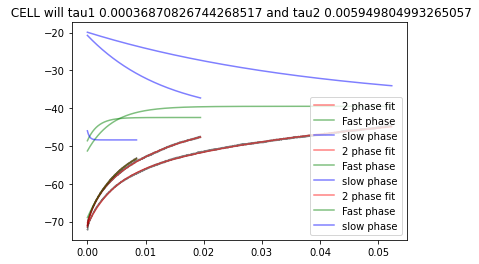

2
[[-43.3093  32.3758  21.1047 -45.7599  21.1047   1.      -1.4134]
 [-46.6663  41.0949  38.0097 -38.4897  38.0097   1.      -0.9366]
 [-49.4434  36.2846  54.1008 -45.3131  54.1008   1.      -1.2488]]
(7,)


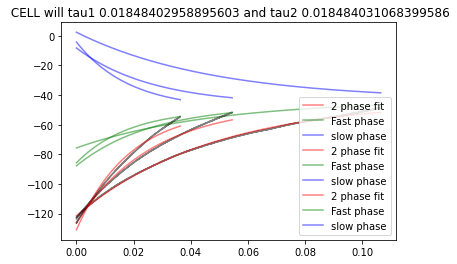

3
[[-47.0325   3.7833 113.7033 -40.6221  15.2523   7.4548 -80.0442]
 [-49.6265  24.1045  30.1996 -19.9514  30.1996   1.      -0.8277]
 [-52.0374  22.8871  45.5715 -18.6904  45.5715   1.      -0.8166]]
(7,)


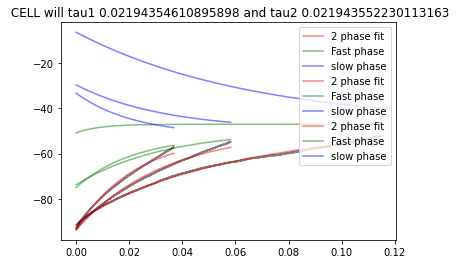

4
[[ -38.4166   23.3396   13.7828  -29.9324   13.7828    1.       -1.2825]
 [ -36.687     2.8426  471.106   -55.6039   17.6736   26.6559 -521.4217]
 [ -36.4734   24.4607   23.231   -33.5379   23.231     1.       -1.3711]]
(7,)


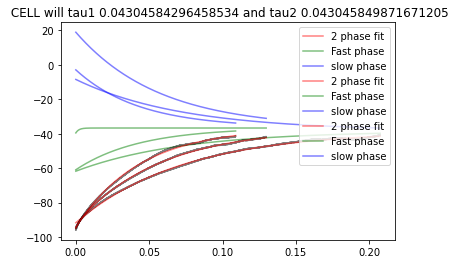

5
6
[[-41.6143  14.1486  25.4425 -18.1785  25.4425   1.      -1.2848]
 [-41.2867  17.2484  39.9663 -17.7284  39.9663   1.      -1.0278]
 [-40.7617  19.8091  53.557  -16.5209  53.557    1.      -0.834 ]]
(7,)


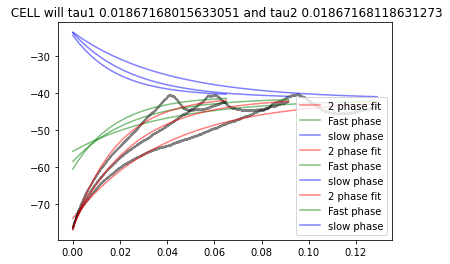

7
8
9
[[-35.2527  19.538  147.8103 -13.8268  16.0015   9.2373  -6.5371]
 [-38.9357   4.4817 325.8151 -25.1857  86.3563   3.7729 -21.2028]
 [-38.9347  12.3296 121.2052 -16.5708 121.2041   1.      -1.344 ]]
(7,)


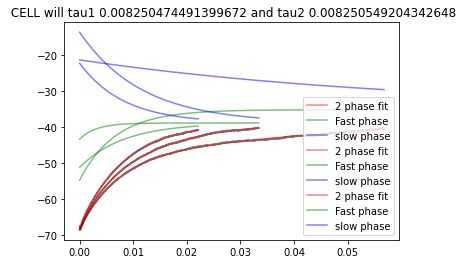

10
[[-32.7808  31.3772  49.2058 -12.3711   9.3156   5.2821  -2.0826]
 [-34.8801  21.499   47.4613 -20.2367  47.4613   1.      -0.9413]
 [-32.931   21.3019  55.1072 -22.3083  55.1072   1.      -1.0472]]
(7,)


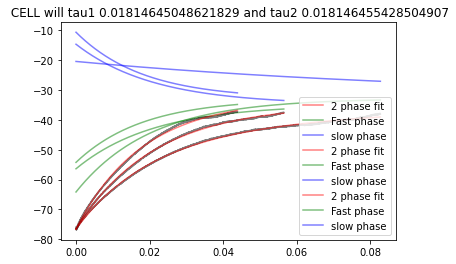

11
[[-36.9617  18.9505  42.7887 -22.0292  42.7887   1.      -1.1625]
 [-39.342   20.2376  64.0447 -18.9623  64.0447   1.      -0.937 ]
 [-43.1873  13.015  105.1871 -16.4107 105.1871   1.      -1.2609]]
(7,)


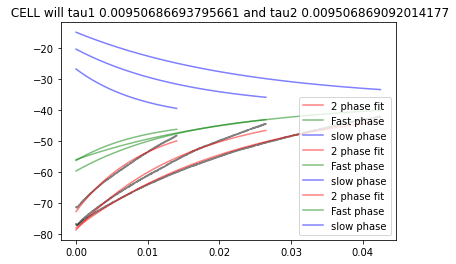

12
13
[[-33.0554  24.3224  87.411  -16.5536  17.1971   5.0829  -3.4594]
 [-35.0478  21.64    71.3338 -16.8303  71.3338   1.      -0.7777]
 [-31.2549  17.7563  81.853  -22.0902  81.853    1.      -1.2441]]
(7,)


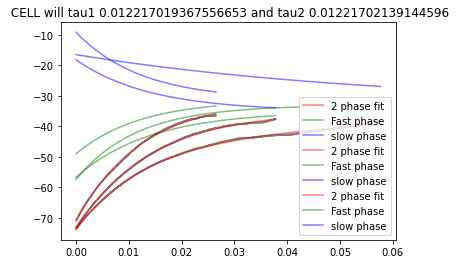

14
[[-28.6914  29.763   66.9366 -20.0494   3.9665  16.8754 -11.3679]
 [-27.6233  31.0702  73.0793 -18.7815   7.6677   9.5308  -5.7612]
 [-27.4402  33.9485  81.6112 -16.0628   9.2469   8.8258  -4.1759]]
(7,)


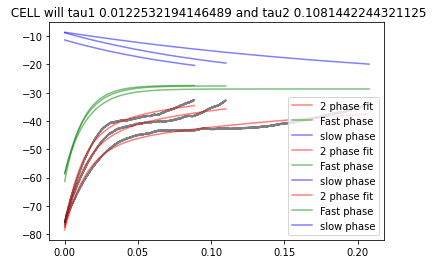

15
[[-32.5671  23.6618 118.9704 -18.9058   5.682   20.9381 -16.7295]
 [-32.2009  22.6638 148.2614 -18.6397   9.49    15.6229 -12.8489]
 [-33.4216  23.6563 166.3893 -15.5492  14.9221  11.1505  -7.3292]]
(7,)


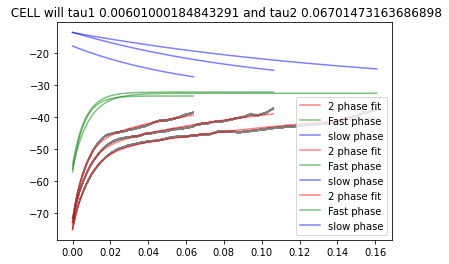

16
17
[[-44.7131  12.6102  64.2021 -12.4225  64.2021   1.      -0.9851]
 [-48.5583  21.4782  46.8492 -24.06    46.8492   1.      -1.1202]
 [-53.6243  21.0772  82.0437 -19.937   82.0437   1.      -0.9459]]
(7,)


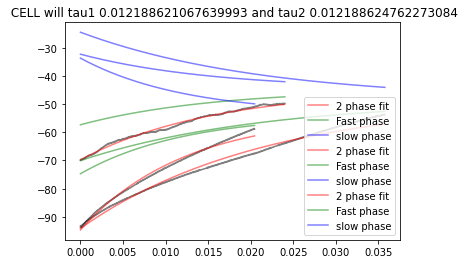

18
[[-45.1404  11.2543  81.34   -27.687    8.3017   9.798  -24.1044]
 [-46.8799  15.6219  28.5989 -17.5375  28.599    1.      -1.1226]
 [-48.2532  15.9967  39.8206 -18.735   39.8206   1.      -1.1712]]
(7,)


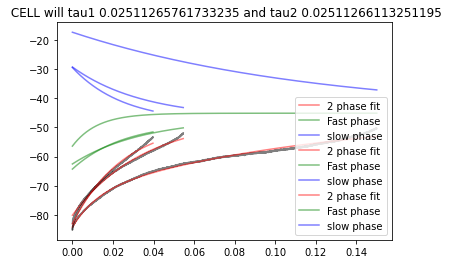

19
[[-34.7339  21.5027  39.8025 -24.4504   2.9752  13.3781 -15.2119]
 [-37.0532   4.6009 191.6887 -39.0863  18.917   10.1331 -86.0847]
 [-39.1284  20.4316  34.5413 -20.0258  34.5413   1.      -0.9801]]
(7,)


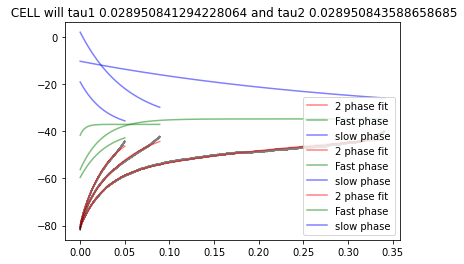

20
[[-46.0559  20.3687  22.23   -23.3069  22.23     1.      -1.1442]
 [-47.7649  21.8743  41.1812 -21.2847  41.1812   1.      -0.973 ]
 [-49.4739  17.0168  61.4276 -24.5307  61.4276   1.      -1.4416]]
(7,)


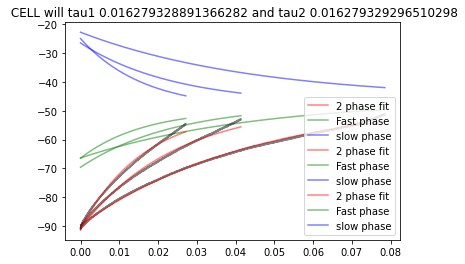

21
[[-39.0979  12.6453  11.515  -21.7194  11.515    1.      -1.7176]
 [-40.4407  15.5156  19.1041 -17.8564  19.1041   1.      -1.1509]
 [-41.2646  15.4453  32.2889 -16.4039  32.289    1.      -1.0621]]
(7,)


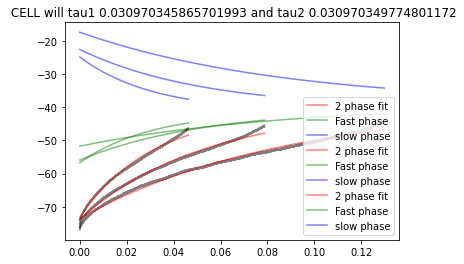

22
[[ -55.9344    1.9809 2234.7654  -10.1737  163.7443   13.6479  -70.0939]
 [ -57.4524    1.298  7089.6107   -9.3447  330.7028   21.438  -154.3407]
 [ -57.5306    1.7428 9232.0796  -10.643   330.8518   27.904  -170.4046]]
(7,)


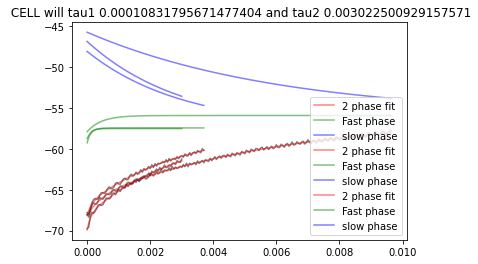

23
[[-31.1328  21.1359  71.4734 -23.5675   8.9538   7.9824  -8.9008]
 [-31.8347  26.6649  65.2075 -17.4373  11.4628   5.6886  -3.72  ]
 [-30.5225  30.4304  68.1633 -15.1381  13.6981   4.9761  -2.4755]]
(7,)


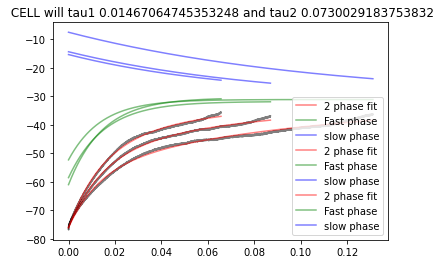

24
[[-37.6542   4.6817 836.7776 -27.8613  95.1988   8.7898 -52.3086]]
(7,)


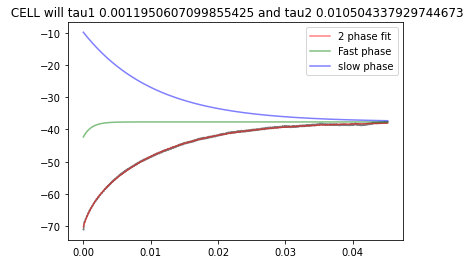

25
[[-33.0554   9.7423 103.3139 -27.5977  17.5737   5.8789 -16.6536]
 [-33.6047  17.8746  43.9273 -19.8185  43.9273   1.      -1.1087]
 [-32.8723  20.1714  63.5005 -17.0393  63.5005   1.      -0.8447]]
(7,)


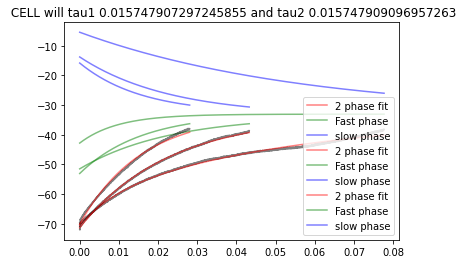

26
[[-32.9028  26.3732  60.6171 -14.8755   4.6694  12.9818  -7.3222]
 [-36.4568  36.4689  45.1003  -1.0244 402.9519   0.1119  -0.0031]
 [-32.8169  20.7019  52.2536 -20.6274  52.2536   1.      -0.9964]]
(7,)


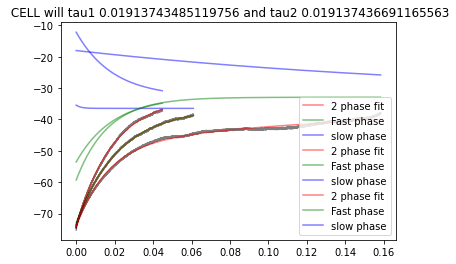

27
[[-31.2244  24.9309 139.4171 -19.7715   6.5752  21.2035 -16.8155]
 [-30.8582  26.0852 158.7898 -19.2363   9.285   17.1018 -12.6116]
 [-30.7666  26.9051 176.5514 -18.7358  12.1929  14.4799 -10.0833]]
(7,)


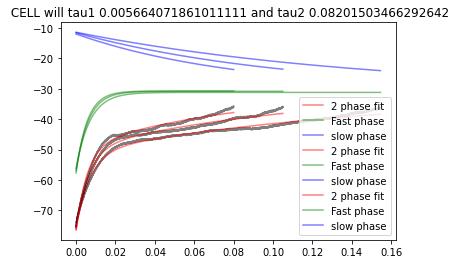

28
[[-32.0483  25.3311  63.1473 -21.222    9.1884   6.8725  -5.7577]
 [-31.1328  29.559   68.2379 -17.3068  13.2841   5.1368  -3.0076]
 [-36.7456  23.3583  68.5272 -17.7295  68.5272   1.      -0.759 ]]
(7,)


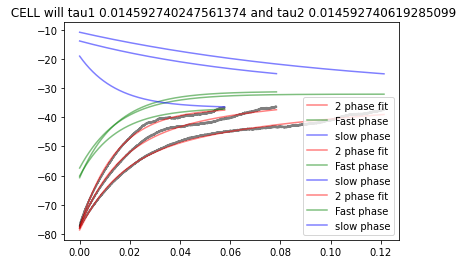

29
[[-35.7104  14.4891  47.3317 -31.9281  12.0863   3.9162  -8.6296]
 [-37.8467  22.5635  30.9208 -22.3559  30.9208   1.      -0.9908]
 [-40.6238  21.732   48.0608 -20.7835  48.0608   1.      -0.9564]]
(7,)


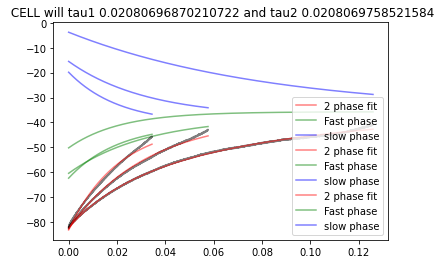

30
[[-32.5671  21.9505  62.1735 -23.3821   7.8631   7.907   -8.4227]
 [-31.9263  23.9431  59.1596 -21.1884  12.4512   4.7513  -4.2047]
 [-31.377   37.2584  48.7901  -8.4243   5.6332   8.6611  -1.9583]]
(7,)


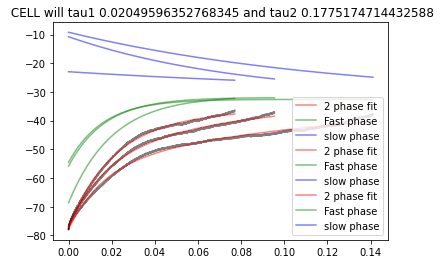

31
[[-31.9263  11.0977   2.0241 -11.3421   2.0241   1.      -1.022 ]
 [-31.4075  28.1806 125.9348 -17.7412   2.2594  55.7382 -35.0901]
 [-31.1938  31.2797 137.5072 -16.9004   2.7125  50.6935 -27.3897]]
(7,)


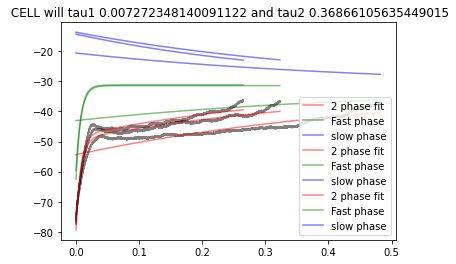

32
[[-31.377   37.5948  42.3853 -17.8371   1.1676  36.3006 -17.2231]
 [-30.2173  41.0113  47.8877 -15.5048   3.627   13.2031  -4.9916]
 [-37.7125  39.7829  47.4163  -9.144   47.4164   1.      -0.2298]]
(7,)


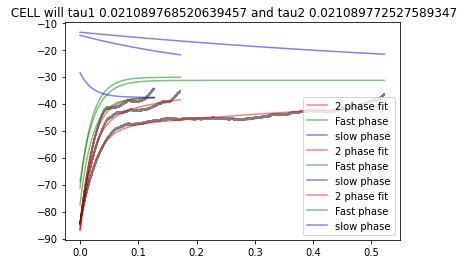

33
34
35
[[-49.1382  21.4624   7.4193 -25.4216   7.4193   1.      -1.1845]
 [-49.5654  21.9897  13.2699 -25.0377  13.2699   1.      -1.1386]
 [-51.0913  22.0898  18.5336 -26.7874  18.5336   1.      -1.2127]]
(7,)


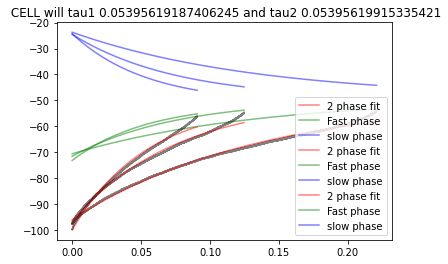

36
37
[[-48.6804  15.2832  18.5763 -19.1435  18.5763   1.      -1.2526]
 [-51.7017  14.6084  32.0123 -18.0812  32.0123   1.      -1.2377]
 [-53.9905  18.3135  46.9805 -12.1839  46.9805   1.      -0.6653]]
(7,)


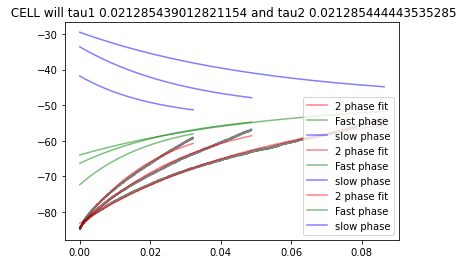

38
fail
39
[[-37.6636  18.9308  39.9928 -21.4102   1.6163  24.7429 -27.9836]
 [-36.6565  10.164   85.2556 -31.8789   9.1207   9.3475 -29.3179]
 [-34.0625   5.1628 165.858  -39.4644  15.2576  10.8705 -83.0938]]
(7,)


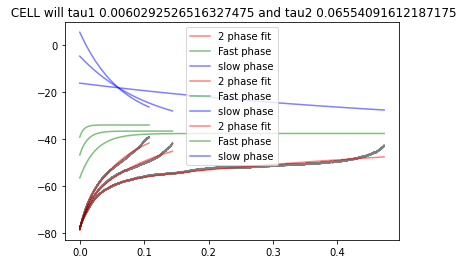

40
[[-41.0205  22.0102  51.9418 -23.7388   1.624   31.9844 -34.4963]
 [-41.2646  24.4734  60.8374 -22.1308   1.7869  34.0467 -30.7879]
 [-41.3257  25.8554  74.3738 -19.7855   2.1764  34.1731 -26.1505]]
(7,)


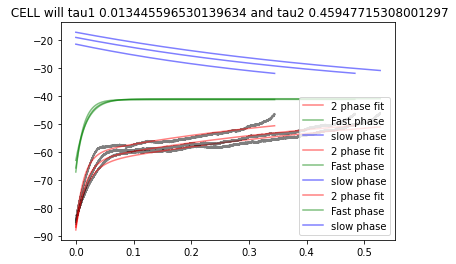

41
fail
42
[[-44.4995  26.2517  30.7334 -26.2047  30.7334   1.      -0.9982]
 [-47.3987  24.4199  50.3731 -28.0748  50.3731   1.      -1.1497]
 [-51.7017  24.2646  75.0257 -24.0941  75.0256   1.      -0.993 ]]
(7,)


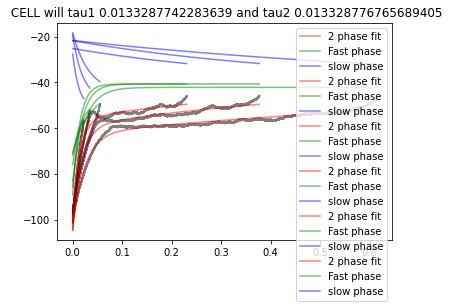

43


In [8]:
curves = []
label = []
ids = []
max_curve = []
for i, f in enumerate(files[:]):
    print(i)
    try:
        base = os.path.basename(f)
        base = base.split(".")[0]
        if base in file_names:
            x, y, c = loadABF(f)
            
            temp_curves =[]
            #plt.clf()
            iterd = 0
            for sweepX, sweepY, sweepC in zip(x,y,c):
                spikext = feature_extractor.SpikeFeatureExtractor(filter=0, end=1.25)
                res = spikext.process(sweepX, sweepY, sweepC)
                if res.empty==False and iterd < 3:
                    iterd += 1
                    spike_time = res['threshold_index'].to_numpy()[0]
                    #plt.figure(num=2)
                    curve, max_dy = exp_growth_factor(sweepX, sweepY, sweepC, spike_time)
                    max_curve.append(max_dy)
                    temp_curves.append(curve)
            temp_curves = np.vstack(temp_curves)
            div = np.ravel((temp_curves[:,2]) / (temp_curves[:,4])).reshape(-1,1)
            
            sum_height= (temp_curves[:,1] + temp_curves[:,3])
            ratio = (temp_curves[:,2] / (temp_curves[:,1] / sum_height)) / (temp_curves[:,4] / (temp_curves[:,3] / sum_height))
            ratio = np.ravel(ratio).reshape(-1,1)
            temp_curves = np.hstack([temp_curves, div, ratio])
            print(temp_curves)
            meanC = np.nanmean(temp_curves, axis=0)
            print(meanC.shape)
            curves.append(meanC)
            label_idx = np.argwhere(file_names==base)
            

            label.append(cell_type_label[label_idx])
            
            ids.append(base)
            plt.savefig(f+".png")
            plt.show()
            
            plt.close()
    except:
        print("fail")
curves = np.vstack(curves)

In [ ]:
#lab = sklearn.preprocessing.LabelEncoder()
#int_lab = lab.fit_transform(label)
print(curves)
label = np.ravel(label).reshape(-1,1)
div = np.ravel((curves[:,2]) / (curves[:,4])).reshape(-1,1)
print(div)
sum_height= (curves[:,1] + curves[:,3])
ratio = (curves[:,2] / (curves[:,1]/sum_height)) / (curves[:,4] / (curves[:,3]/sum_height))
ratio = np.ravel(ratio).reshape(-1,1)
curves_out = np.hstack([curves, div, ratio, label])
np.savetxt('curves.csv', curves_out, fmt='%.8f', delimiter=',')
np.savetxt('curves_id.csv', ids, fmt='%s', delimiter=',')
print(curves)

[[-43.3712   7.3192 462.3941 -19.8775  81.4277   7.0751 -20.4409]
 [-46.473   43.8712  37.7384 -35.9014  37.7384   1.      -0.8331]
 [-49.5654  26.8996  30.2253 -16.3826  52.245    0.728   -0.7835]
 [-37.1923  35.9201  18.1311 -19.917   23.1562   0.8452  -0.707 ]
 [-41.2209  18.5298  39.6553 -16.0149  39.6553   1.      -0.8814]
 [-37.7077  12.9103 198.2767 -17.7339  74.5207   4.6701  -9.5681]
 [-33.5306  26.0791  50.5914 -16.9523  37.2947   2.4274  -1.2429]
 [-39.8303  18.796   70.6735 -17.7391  70.6735   1.      -0.9527]
 [-33.1194  22.1798  80.1993 -17.5512  56.7946   2.361   -1.7236]
 [-27.9183  31.5939  73.8757 -18.2979   6.9604  11.744   -7.1017]
 ...
 [-34.3778  18.9466  58.5627 -44.7964  25.8102   3.0772 -10.7285]
 [-30.3597  34.022   66.464  -26.6795   8.5818   8.8236  -9.783 ]
 [-53.8582  35.2647  70.0261 -46.8138  21.4017   6.0705 -14.275 ]
 [-34.4389  52.3701  32.8181 -25.2211  50.2188   0.7481  -0.5703]
 [-37.4398  21.6045  61.2256 -20.6985 108.0637   4.0405 -19.3857]
 [-38

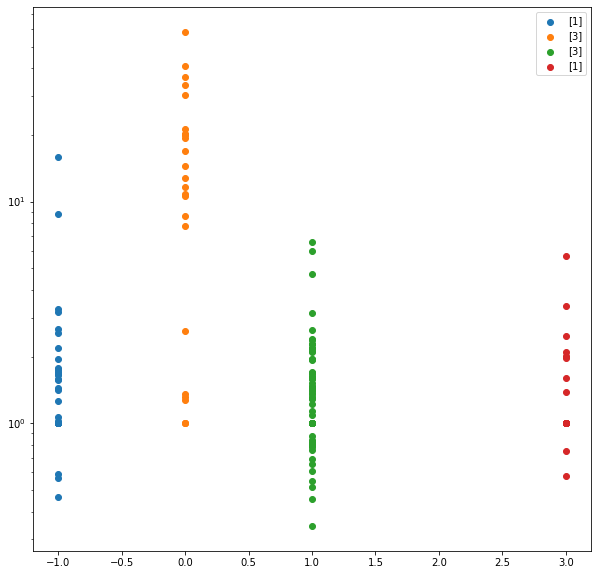

In [ ]:
means = []
plt.figure(figsize=(10,10))
plt.clf()
for x in np.unique(label).astype(np.int32):
    idx = np.argwhere(label[:,0]==x).astype(np.int32)
    mcur = curves[idx]
    plt.scatter(np.full(len(idx),  x),  (curves[idx,2]) / (curves[idx,4]), label=label[x])
    means.append(np.nanmean((curves[idx,2]) / (curves[idx,4])))
plt.legend()
plt.yscale('log')
#plt.ylim(0,1)

In [ ]:
print(means)

In [ ]:
1=1
curves = []
label = []
ids = []
for i, f in enumerate(files[:38]):
    print(i)
    x, y, c = loadABF(f)
    d_name = os.path.dirname(f)
    base = os.path.basename(f)
    ids.append(base)
    label.append(d_name)
    dfs = []
    temp_curves
    plt.clf()
    for sweepX, sweepY, sweepC in zip(x,y,c):
        spikext = feature_extractor.SpikeFeatureExtractor(filter=0)
        res = spikext.process(sweepX, sweepY, sweepC)
        dfs.append(res)
        if res.empty==False:
            if len(non_empty_df) > 1:
                sweep_to_use = non_empty_df[1]
            else:
                sweep_to_use = non_empty_df[-1]
    non_empty_df = np.nonzero(np.invert([df.empty for df in dfs]))[0]
    
    
    try:
        spike_time = dfs[sweep_to_use]['threshold_index'].to_numpy()[0]
        curve = exp_growth_factor(x[sweep_to_use,:], y[sweep_to_use,:], c[sweep_to_use,:], spike_time)
        curves.append(curve)
    except:
        curves.append([np.nan, np.nan, np.nan, np.nan, np.nan])
    plt.show()
print(non_empty_df)